Traitement des données manquantes : Analyse comparative des méthodes d'imputation

Dans cette partie, nous étudions deux approches pour gérer les données manquantes :
1. La suppression complète des observations avec données manquantes
2. L'imputation adaptée selon le type de variable :
    - Pour les variables quantitatives : imputation par la médiane
    - Pour les variables qualitatives : imputation par le mode

Notre objectif est de construire un modèle capable de prédire les hémorragies du post-partum (HPP) nécessitant une transfusion, 
identifiées par la variable hpp_trans. Face à ce problème de classification binaire déséquilibré, 
nous avons choisi le score F1 comme métrique d'évaluation.

L'évaluation des stratégies d'imputation sera réalisée à travers trois modèles de classification :
- Un modèle de régression logistique
- Un modèle de forêts aléatoires
- Un modèle XGBoost

Les paramètres par défaut seront conservés pour chaque modèle.

In [1]:
# Bibliothèques standards
import logging
import os

# Bibliothèques de données et calcul scientifique
import joblib
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# MLflow
import mlflow
import mlflow.data.pandas_dataset
import mlflow.sklearn

# Scikit-learn - Prétraitement
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

# Scikit-learn - Modélisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                   StratifiedKFold, train_test_split)
from sklearn.pipeline import Pipeline

# Scikit-learn - Métriques
from sklearn.metrics import (ConfusionMatrixDisplay, auc, classification_report,
                           f1_score, make_scorer, precision_recall_curve,
                           precision_score, recall_score, roc_auc_score,
                           roc_curve)

# Imbalanced-learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# XGBoost
from xgboost import XGBClassifier


In [2]:
df_dico = pd.read_csv('Project/clean/description_variable_clean.csv',index_col=0)
df_model = pd.read_csv('Project/clean/Bourgogne20132023_clean.csv', index_col=0)

In [3]:
df_model.head()

,age_m,taille_mere,bmi,tabac,parite,diabete,hta_tot,cholestase,preecl,hellp,...,cortico,AMP,pma,hosp_m_g,dsm_g,bilan,nbilan,nsej18,terme,hpp_trans
0,28.0,NaN,NaN,0,NaN,0,0,0,0,0,...,0,Aucune,0,1,2.0,0,0,1,39.9,0
1,27.0,178.0,23.4,0,0.0,0,0,0,0,0,...,0,Aucune,0,1,2.0,0,0,0,41.6,0
2,36.0,167.0,22.2,0,2.0,0,0,0,0,0,...,0,Aucune,0,1,1.0,0,0,0,41.2,0
3,35.0,159.0,17.0,0,0.0,0,0,0,0,0,...,0,Aucune,0,0,0.0,0,0,0,38.6,0
4,30.0,NaN,NaN,0,NaN,0,0,0,0,0,...,0,Aucune,0,2,5.0,0,0,1,39.9,0


In [4]:
# Fonction pour mettre à jour les listes de features en fonction du dictionnaire de variables
def update_list_features(X_train, df_dico):
    df_dico = df_dico.reindex(X_train.columns)
    quant_features = df_dico[df_dico['type_var'] == 'Quantitative'].index.tolist()
    binary_features = df_dico[df_dico['type_var'] == 'Binaire'].index.tolist()
    nominal_features = df_dico[df_dico['type_var'] == 'Nominale'].index.tolist()
    ordinal_features = df_dico[df_dico['type_var'] == 'Ordinale'].index.tolist()
    return quant_features, binary_features, nominal_features, ordinal_features

In [5]:
### Dataset sans suppression des lignes comportant des valeurs manquantes.

X=df_model.drop(['hpp_trans'],axis=1)
y=df_model["hpp_trans"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

quant_features, binary_features, nominal_features, ordinal_features = update_list_features(X_train, df_dico)

print('Nombre de lignes et de colonnes de X_train : ',X_train.shape,'\n')


print(X_train[:5])

print("Quantitative features : ",quant_features)
print("Binaire features : ",binary_features)
print("Nominal features : ",nominal_features)
print("Ordinale features : ",ordinal_features)



Nombre de lignes et de colonnes de X_train :  (52427, 22) 

       age_m  taille_mere   bmi  tabac  parite  diabete  hta_tot  cholestase  \
15263   29.0        163.0  30.9      0     1.0        0        0           0   
30669   28.0        169.0  30.1      1     2.0        0        0           0   
9685    48.0        163.0  21.5      0     1.0        0        0           0   
13052   30.0          NaN   NaN      0     NaN        0        0           0   
31781   38.0        160.0  29.3      0     1.0        0        0           0   

       preecl  hellp  ...  ut_cica  cortico     AMP  pma hosp_m_g  dsm_g  \
15263       0      0  ...        1        0  Aucune    0        0    0.0   
30669       0      0  ...        0        0  Aucune    0        0    0.0   
9685        0      0  ...        0        0  Aucune    1        0    0.0   
13052       0      0  ...        0        0  Aucune    0        0    0.0   
31781       0      0  ...        0        0  Aucune    0        0    0.0   

  

In [6]:
### Dataset avec suppression des lignes comportant des valeurs manquantes.

df_model_dropna=df_model.copy().dropna()

X_dropna=df_model_dropna.drop(['hpp_trans'],axis=1)
y_dropna = df_model_dropna["hpp_trans"]


X_train_dropna, X_test_dropna, y_train_dropna, y_test_dropna = train_test_split(X_dropna, y_dropna, test_size=0.20, stratify=y_dropna, random_state=42)

print('Nombre de lignes et de colonnes de X_train : ',X_train_dropna.shape,'\n')


Nombre de lignes et de colonnes de X_train :  (42350, 22) 



In [7]:
def train_evaluate_model_imputation(model):
    # Construction du pipeline
    # Création des transformateurs pour chaque type de variable
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    binary_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

    nominal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first'))
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder())
    ])

    # Création du preprocesseur avec ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, quant_features),
            ('bin', binary_transformer, binary_features),
            ('nom', nominal_transformer, nominal_features),
            ('ord', ordinal_transformer, ordinal_features)
        ])

    # Pipeline complet avec le modèle
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entraînement du modèle
    pipeline.fit(X_train, y_train)

    return pipeline

In [8]:
def train_evaluate_model_dropna(model):
    # Création des transformateurs pour chaque type de variable
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first'))
    ])

    ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())
    ])

    # Création du preprocesseur avec ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, quant_features),
            ("bin", "passthrough", binary_features), 
            ('nom', nominal_transformer, nominal_features),
            ('ord', ordinal_transformer, ordinal_features)
        ])

    # Pipeline complet avec le modèle
    pipeline_dropna = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entraînement du modèle
    pipeline_dropna.fit(X_train_dropna, y_train_dropna)
    
    return pipeline_dropna

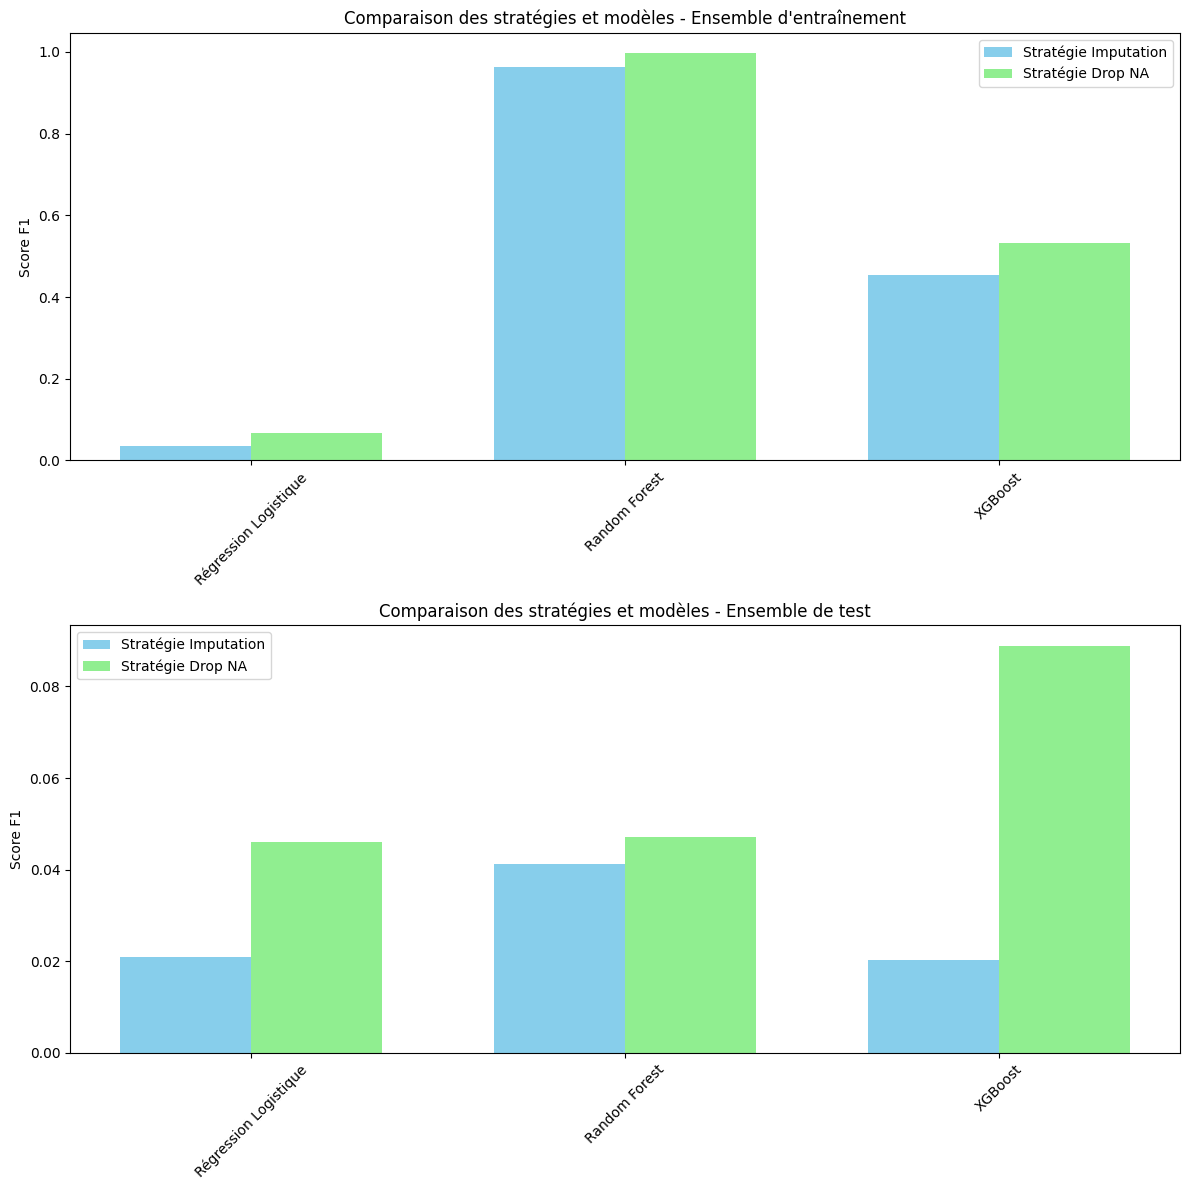

In [9]:
# Création des modèles
models = {
    'Régression Logistique': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Dictionnaire pour stocker les scores
scores = {
    'Train_Imputation': [],
    'Train_Drop_NA': [],
    'Test_Imputation': [],
    'Test_Drop_NA': []
}

model_names = []

# Évaluation des modèles
for name, model in models.items():
    # Pipeline avec imputation
    pipeline_imp = train_evaluate_model_imputation(model)
    y_pred_train_imp = pipeline_imp.predict(X_train)
    y_pred_test_imp = pipeline_imp.predict(X_test)
    scores['Train_Imputation'].append(f1_score(y_train, y_pred_train_imp))
    scores['Test_Imputation'].append(f1_score(y_test, y_pred_test_imp))
    
    # Pipeline avec drop NA
    pipeline_drop = train_evaluate_model_dropna(model)
    y_pred_train_drop = pipeline_drop.predict(X_train_dropna)
    y_pred_test_drop = pipeline_drop.predict(X_test_dropna)
    scores['Train_Drop_NA'].append(f1_score(y_train_dropna, y_pred_train_drop))
    scores['Test_Drop_NA'].append(f1_score(y_test_dropna, y_pred_test_drop))
    
    model_names.append(name)

# Création des graphiques de comparaison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

x = np.arange(len(model_names))
width = 0.35

# Graphique pour les scores d'entraînement
ax1.bar(x - width/2, scores['Train_Imputation'], width, label='Stratégie Imputation', color='skyblue')
ax1.bar(x + width/2, scores['Train_Drop_NA'], width, label='Stratégie Drop NA', color='lightgreen')
ax1.set_ylabel('Score F1')
ax1.set_title('Comparaison des stratégies et modèles - Ensemble d\'entraînement')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Graphique pour les scores de test
ax2.bar(x - width/2, scores['Test_Imputation'], width, label='Stratégie Imputation', color='skyblue')
ax2.bar(x + width/2, scores['Test_Drop_NA'], width, label='Stratégie Drop NA', color='lightgreen')
ax2.set_ylabel('Score F1')
ax2.set_title('Comparaison des stratégies et modèles - Ensemble de test')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [10]:
# Enregistrement des résultats dans MLflow
import mlflow

# Configuration MLflow
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "https://thibautmodrin-mlflow.hf.space"))
mlflow.set_experiment("HPP_Prediction_Imputation_Strategy")
experiment = mlflow.get_experiment_by_name("HPP_Prediction_Imputation_Strategy")

client = mlflow.tracking.MlflowClient()

# Pour chaque modèle et chaque stratégie
for i, model_name in enumerate(model_names):
    # Run pour la stratégie d'imputation
    run_imp = client.create_run(experiment.experiment_id, run_name=f"{model_name}_imputation")
    with mlflow.start_run(run_id=run_imp.info.run_id) as run:
        mlflow.sklearn.autolog()
        
        # Logging des métriques
        mlflow.log_metric("train_score", scores['Train_Imputation'][i])
        mlflow.log_metric("test_score", scores['Test_Imputation'][i])
        
        # Logging des paramètres
        mlflow.log_param("strategie", "imputation")
        mlflow.log_param("model", model_name)
        mlflow.log_param("metrique", "F1-score")
    
    # Run pour la stratégie drop NA
    run_drop = client.create_run(experiment.experiment_id, run_name=f"{model_name}_dropna")
    with mlflow.start_run(run_id=run_drop.info.run_id) as run:
        mlflow.sklearn.autolog()
        
        # Logging des métriques
        mlflow.log_metric("train_score", scores['Train_Drop_NA'][i])
        mlflow.log_metric("test_score", scores['Test_Drop_NA'][i])
        
        # Logging des paramètres
        mlflow.log_param("strategie", "dropna")
        mlflow.log_param("model", model_name)
        mlflow.log_param("metrique", "F1-score")

# Sauvegarde des graphiques de comparaison dans un run séparé
run_viz = client.create_run(experiment.experiment_id, run_name="visualisation_comparaison")
with mlflow.start_run(run_id=run_viz.info.run_id) as run:
    # Sauvegarde des graphiques
    plt.figure(fig.number)
    mlflow.log_figure(fig, "comparaison_strategies.png")
    
    # Création et sauvegarde du DataFrame récapitulatif
    resultats_df = pd.DataFrame({
        'Modele': model_names,
        'Train_Score_Imputation': scores['Train_Imputation'],
        'Test_Score_Imputation': scores['Test_Imputation'],
        'Train_Score_DropNA': scores['Train_Drop_NA'],
        'Test_Score_DropNA': scores['Test_Drop_NA']
    })
    
    # Sauvegarde du DataFrame
    resultats_df.to_csv("resultats_comparaison.csv")
    mlflow.log_artifact("resultats_comparaison.csv")
    
    # Logging des paramètres généraux
    mlflow.log_param("nombre_modeles", len(model_names))
    mlflow.log_param("modeles_testes", ", ".join(model_names))


🏃 View run Régression Logistique_imputation at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/5dab463ad797486e9579643d3f71a8b6
🧪 View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
🏃 View run Régression Logistique_dropna at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/84df3cb80aed459f8f847d3008ada82b
🧪 View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
🏃 View run Random Forest_imputation at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/a61aba8558914797980b3be735fb6ed7
🧪 View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
🏃 View run Random Forest_dropna at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/4503dd2fa06c46d28115691c20b39454
🧪 View experiment at: https://thibautmodrin-mlflow.hf.space/#/experiments/37
🏃 View run XGBoost_imputation at: https://thibautmodrin-mlflow.hf.space/#/experiments/37/runs/d156c95edfdc4b208ed6744a5da9c3f7
🧪 View experiment at: htt

<Figure size 640x480 with 0 Axes>

### Notre analyse comparative révèle que l'approche de suppression des observations avec valeurs manquantes (dropna) offre de meilleures performances que la stratégie d'imputation. Nous avons donc retenu cette méthode pour la suite du projet.
### 
### Cette décision comporte néanmoins des implications importantes pour le déploiement de notre outil prédictif. Les données nouvellement chargées dans l'application de prédiction devront être complètes, sans valeurs manquantes, sous peine d'être exclues de l'analyse. Cela nécessite un travail considérable de sensibilisation auprès des utilisateurs pour garantir la collecte exhaustive des variables. Par ailleurs, une réflexion approfondie s'impose sur la sélection des variables les plus pertinentes pour la prédiction. Il pourrait être judicieux de réduire leur nombre en ne conservant que les plus significatives, facilitant ainsi la collecte de données complètes. Cette sélection devra également tenir compte de l'influence des variables sur les différents modèles.